<a href="https://colab.research.google.com/github/channayousif/Agentic_AI/blob/main/langchain_multimodal%20curriculum%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [3]:
# for linux
!sudo apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# %brew install poppler tesseract libmagic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libmagic-dev poppler-utils tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 5 newly installed, 0 to remove and 19 not upgraded.
Need to get 5,107 kB of archives.
After this operation, 16.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libmagic-dev amd64 1:5.41-3ubuntu0.1 [105 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 te

In [4]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community
%pip install -Uq python_dotenv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.6/514.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import os
from google.colab import userdata

# keys for the services we will use

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["PINECONE_API_KEY"] = userdata.get('PINECONE_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"


In [1]:
from google.colab import drive


drive.mount('/content/drive')


"""# Mount a specific local folder
local_folder_path = 'D:/curriculum_project'
mount_point = '/content/local_folder'
os.makedirs(mount_point, exist_ok=True)
os.system(f'mount -o bind {local_folder_path} {mount_point}')"""

Mounted at /content/drive


"# Mount a specific local folder\nlocal_folder_path = 'D:/curriculum_project'\nmount_point = '/content/local_folder'\nos.makedirs(mount_point, exist_ok=True)\nos.system(f'mount -o bind {local_folder_path} {mount_point}')"

In [72]:
from google.colab import drive
drive.flush_and_unmount()

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [6]:

output_path = "./drive/MyDrive/PDFs/"
urls = [
"https://dcar.gos.pk/Sindh-Curriculum/Advanced%20Pak%20Studies%20Grade%20XI-XII%20%202021%20with%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Matrix%20for%20Curriculum%20Review%202024-25.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Advanced%20Pak%20Studies%20Grade%20XI-XII%20%202021%20with%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Aasan%20Sindhi%20Curriculum%20Grade%20III-V%202024%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Aasan%20Urdu%20Grade%20III-V.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Biology_Curriculum_19_August_2024_with_Notification[2].pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Sindh%20Curriculum%20for%20Biology%20Grades%20XI-XII%20%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Chemistry%20Curriculum%20%20Grade%20IX-XII%2019%20August%202024%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Chemistry%20Curriculum%20Grade%20IX-X%20Revised%202017.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Chemistry%20Curriculum%20Grade%20XI-XII%20with%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Computer%20Science%20Curriculum%20Grade%20VI-VIII%202024%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Computer%20Science%20Curriculum%20with%20NOC-2024.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Computer%20Science%20Curriculum%20Grade%20XI-XII%202019%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Computer%20Science%20Curriculum%20Grade%20IX-X%202018%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Disaster%20Risk%20Reduction%20&%20Resilience%20August%202020.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Drawing%20Curriculum%20VI-VIII%20-15-01-2022.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/ECCE%20Standared.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/ECCE%202018-2.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/ECE%20Curriculum%20-%2007%20August%20%202024%20.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/English%20Curriculum%20Grade%20K-VIII%202024%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/English%20Language%20Curriculum%20Grade%20IX-XII%2021%20JUNE%202024.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Revised%20English%20Curriculum%20ECE-XII_2.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Revised%20English%20Literature%20XI-XII%20with%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Sindh%20Curriculum%20for%20ETHICS%20Grade%20III%20to%20V%20with%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/FINAL%20DRAFT%20OF%20ETHICS(Grade%20VI-%20VIII)%2014-02-2020%20with%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Ethics%20Curriculum%20XI-XII%20Review%20on%2030-11-2020.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/General%20Science%20Grade%20IV-VIII%2002%20May%202024.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/General%20Knowledge%20Curriculum%20Sindh%20Grade%20I%20to%20III%20-%204%20April%202024%20with%20Notify.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Final%20Copy%20Islamiat%20Curriculum%20III-VIII.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Final%20Copy%20%20Islamiat%20Ix-X%20Syllabus%202017%20updated.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Final%20Copy%20Islamiat%20Curriculum%20XI-XII%202018%20.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Its%20All%20One%20Curriculum.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Libarary%20Science%20Grade%20XI-XII%2013%20August%202024.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Mathematic%20Curriculum%20Grade%20I-VIII%202024%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Maths%20Curriculum%202024%20Grade%20IX-XII-15%20JULY%202024.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Curriculum%20for%20Mathematics%20Grades%20XI-XII%20(Revised%20in%202019).pdf",
"https://dcar.gos.pk/National_Curriculum/Pakistan%20Studies%20Grade%20IX-X%202019%20Final%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Pakistan%20Studies%20Grade%20IX-X-2019-2020-Revised.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Sindh%20Curriculum%20for%20Physical%20Education%20Grades%20I-VIII%202019%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Physics%20Curriculum%2019%20August%202024.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Physics%20Grades%20IX-X%202018.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Physics%20Curriculum%20Grades%20XI%20-XII,%20Notified%2025-11-2019.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/RS-G%20III-V%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/RS-G%20VI-VIII%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/RS-G%20IX-X%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/RS-G%20XI-XII%20Notified.pdf",
"https://dcar.gos.pk/National_Curriculum/Reviewed%20Social%20Srtudies%20Final%20Curriculum%202016.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Sindh%20Curriculum%20for%20the%20Subject%20of%20Sindhi%20Grade%20I-V.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Sindhi%20Curriculum%20Grade%20VI-VIII%20%202022%20with%20Notification.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Sindhi%20Language%20Curriculum%20Grade%20XI-XII%20with%20Notified.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Sindh%20Curriculum%20for%20the%20Subject%20of%20Urdu%20Grade%20I-V.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Urdu%20Curriculum%20VI-VIII.pdf",
"https://dcar.gos.pk/Sindh-Curriculum/Urdu%20Curriculum%20Grade%20XI-XII%20with%20Notification%20and%20Signature.pdf",
"https://dcar.gos.pk/other_notifications/Newsletter-05%20December%202023.pdf"]

from urllib.parse import urlparse
import os

def extract_filename_from_url(url):
    """Extract the filename from a URL.

    Args:
        url (str): The complete URL.

    Returns:
        str: The extracted filename.
    """
    # Parse the URL
    parsed_url = urlparse(url)
    # Get the last part of the path
    filename = os.path.basename(parsed_url.path)
    return filename


for url in urls:
  # Download the PDF to a local file
  local_file_name = extract_filename_from_url(url)
  local_file_path = output_path + local_file_name
  response = requests.get(url, stream=True)
  with open(local_file_path, "wb") as f:
    f.write(response.content)

NameError: name 'requests' is not defined

In [ ]:
from unstructured.partition.pdf import partition_pdf
from langchain.document_loaders import UnstructuredURLLoader
import requests



import pickle
import os

def save_chunks(chunks, filename):
    """Saves chunks to a file."""
    filepath = os.path.join(output_path,"chunk_data", filename + ".pkl")  # Create a subfolder for organization
    os.makedirs(os.path.dirname(filepath), exist_ok=True)  # Ensure the directory exists
    with open(filepath, 'wb') as f:
        pickle.dump(chunks, f)


chunk_data=[]
import os

def list_pdfs(folder_path):
    """Lists all PDF files in a folder.

    Args:
        folder_path (str): The path to the folder.

    Returns:
        list: A list of PDF file paths.
    """
    pdf_files = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            pdf_files.append(filename)
    return pdf_files

# Get the list of PDF files
folder_path = "/content/drive/MyDrive/PDFs"
pdf_files = list_pdfs(folder_path)

# Print the list
for pdf_file in pdf_files:
  if pdf_file+".pkl" in os.listdir("/content/drive/MyDrive/PDFs/chunk_data"):
    continue
  else:
    print(os.path.join(folder_path, pdf_file))
    # Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
    chunks = partition_pdf(
    filename=os.path.join(folder_path, pdf_file),
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=output_path+"/img",   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
    )
    # filename = extract_filename_from_url(url)
    save_chunks(chunks, pdf_file)
    chunk_data.append(chunks)

/content/drive/MyDrive/PDFs/Chemistry%20Curriculum%20%20Grade%20IX-XII%2019%20August%202024%20with%20Notification.pdf


In [15]:
os.listdir("/content/drive/MyDrive/PDFs/chunk_data")




['Advanced%20Pak%20Studies%20Grade%20XI-XII%20%202021%20with%20Notified.pdf.pkl',
 'Matrix%20for%20Curriculum%20Review%202024-25.pdf.pkl',
 'Aasan%20Sindhi%20Curriculum%20Grade%20III-V%202024%20with%20Notification.pdf.pkl',
 'Aasan%20Urdu%20Grade%20III-V.pdf.pkl',
 'Biology_Curriculum_19_August_2024_with_Notification[2].pdf.pkl',
 'Sindh%20Curriculum%20for%20Biology%20Grades%20XI-XII%20%20with%20Notification.pdf.pkl']

In [ ]:
import pickle
import os

def load_chunks(filename):
    """Loads chunks from a file."""
    filepath = os.path.join(output_path,"chunk_data", filename + ".pkl")
    with open(filepath, 'rb') as f:
        return pickle.load(f)

filename = "your_pdf_filename"  # Replace with the desired filename
chunks = load_chunks(filename)

In [86]:
chunks

In [87]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [88]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[0].metadata.orig_elements

In [89]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[0].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'd1af881c-a168-4ec3-9440-414cd38070a9',
 'text': '                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               ',
 'metadata': {'coordinates': {'points': ((87.65555555555555,
     0.5555555555556818),
    (87.65555555555555, 1389.4444444444443),
    (619.8222222222223, 1389.4444444444443),
    (619.8222222222223, 0.5555555555556818)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-02-08T14:30:19',
  'filetype': 'PPM',
  'languages': ['eng']

### Separate extracted elements into tables, text, and images

In [90]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [91]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

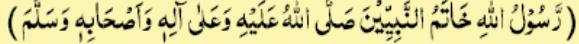

In [93]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[10])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [94]:
%pip install -Uq langchain-google-genai langchain_groq

In [95]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [98]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [97]:
# Summarize text
# text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

import time

# Summarize text with rate limiting
text_summaries = []
for text in texts:
    text_summaries.append(summarize_chain.invoke(text))
    time.sleep(5)  # Wait for 15 seconds, adjust as needed

# Summarize tables with rate limiting
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = []
for table_html in tables_html:
    table_summaries.append(summarize_chain.invoke(table_html))
    time.sleep(5)  # Wait for 15 seconds, adjust as needed



# Summarize tables
# tables_html = [table.metadata.text_as_html for table in tables]
# table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [42]:
text_summaries

["The Sindh Government's School Education & Literacy Department has revised the Pakistan Studies curriculum for Grades XI-XII, with a focus on developing students' understanding of Pakistan's history, society, culture, geography, economy, and politics. The curriculum is divided into six strands: History, Geography, Political Science/Civics, Economics, Sociology, and Skill Development. The revised curriculum aims to promote critical thinking, self-reliance, and employability, while removing biases and discriminations based on various social factors.",
 'The curriculum focuses on democratic norms, creativity, and critical thinking, promoting national integration and developing skills in inquiry, research, and learning. It emphasizes the study of history to understand the past, present, and predict the future, with standards and benchmarks for students to learn chronological skills, sequence key events, and identify relationships and patterns of historical change and continuity.',
 'The b

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [43]:
from langchain_google_genai import ChatGoogleGenerativeAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

# Create the model
generation_config = {
  "temperature": .6,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

modell = ChatGoogleGenerativeAI(
  model="gemini-2.0-flash",
  generation_config=generation_config,
)


chain = prompt | modell | StrOutputParser()


# image_summaries = chain.batch(images)

image_summaries = []
for image in images:
    image_summaries.append(chain.invoke({"image": image}))
    time.sleep(7)  # Introduce a delay of 5 seconds between each request

In [44]:
image_summaries

['The image is a repeating pattern on a maroon background, featuring stylized floral and geometric elements.\n\nThe most prominent feature is a series of circles arranged vertically. Each circle has a black interior with eight white petal-like shapes radiating from the center. The circle is bordered by a white ring dotted with small black circles.\n\nSurrounding each main circle are stylized floral designs. These consist of a smaller white four-petal flower shape and a black four-leaf clover-like shape. These shapes are arranged in a way that they appear to encircle the main circle, creating a secondary, less defined circular pattern around it.\n\nThe overall effect is a dense, repeating pattern with a strong contrast between the maroon background and the black and white elements. The pattern is symmetrical and visually complex, drawing the eye to the interplay of shapes and colors. Given the context of a research paper explaining the transformer architecture, the pattern could be used

In [45]:
print(image_summaries[10])

The image shows a line of text in Arabic script. The text is black and is displayed against a light yellow background. The script is ornate and flowing, characteristic of Arabic calligraphy. The text is centered within the image frame. Because it is part of a research paper explaining the transformers architecture, it is probably used to illustrate a concept of translation. However, it's impossible to extract any information about bar plots, graphs, or anything else related to transformers.


## Load data and summaries to vectorstore

In [46]:
!pip install -Uq langchain-pinecone


### Create the vectorstore

In [47]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
#from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_pinecone import PineconeVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Pinecone vector store
from pinecone import Pinecone, ServerlessSpec

# Initialize Pinecone client
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

index_name = "curriculum-project"

# Create index if it doesn't exist
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=768,  # Match this to your embedding model's dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

# Connect to the index
index = pc.Index(index_name)

# Create vector store
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embeddings
)


# The vectorstore to use to index the child chunks
#vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

### Load the summaries and link the to the original data

In [48]:




# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
if summary_tables:  # Check if summary_tables is not empty
 retriever.vectorstore.add_documents(summary_tables)
 retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))


### Check retrieval

In [49]:
# Retrieve
docs = retriever.invoke(
    "what is curriculum?"
)

In [50]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

## RAG pipeline

In [51]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | modell
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | modell
        | StrOutputParser()
    )
)

In [52]:
response = chain.invoke(
    "What is the curriculum?"
)

print(response)

I cannot answer the question "What is the curriculum?" because the provided context does not contain any information about the curriculum.


In [99]:
response = chain_with_sources.invoke(
    "What is curriculum?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: Based on the context, curriculum:

*   Attaches great importance to democratic norms and positive cultural values.
*   Creates thrust for creativity, development of critical thinking, discussion and debate.
*   Develops among students the skills of inquiry, research, and build the capacity of learning, behaving, acting and communicating.
*   Plays an important role in promoting national integration.


Context:
Page 1 of 77

relationship, tolerance and harmony in society. It attaches great importance to democratic norms and positive cultural values. The curriculum creates thrust for creativity, development of critical thinking, discussion and debate. It develops among students the skills of inquiry, research, and build the capacity of learning, behaving, acting and communicating. The curriculum plays an important role in promoting national integration.

Page 2 of 77

Curriculum standards and Benchmarks

2.0 Curriculum Standards and Benchmarks

HISTORY

History is the study of 

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)